# Regularization

1. Ridge - Penalty is applied on square of coefficients
2. Lasso - Penalty is applied on absolute values of coefficient

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

# Step 1 - Data ingestion

In [2]:
import pandas as pd

df = pd.read_csv("Cars93.csv", na_values=["", "NA"], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,4,1.8,140,6300,2890,Yes,13.2,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,3.2,200,5500,2335,Yes,18.0,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,2.8,172,5500,2280,Yes,16.9,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,3.5,208,5700,2545,Yes,21.1,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


# Weight the target feature

# Step 2 - Perform basic data quality checks

In [3]:
df.shape

(94, 28)

In [4]:
df.duplicated().sum()

np.int64(1)

In [5]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)
df.shape

(93, 28)

In [6]:
m = df.isna().sum()
m[m > 0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

In [8]:
def get_high_card_cols(df, threshold=0.9):
    cat_unique = df.select_dtypes(include="object").nunique()
    cardinality = cat_unique / len(df)
    high_card = cardinality[cardinality >= threshold]
    print(high_card)
    return high_card.index.tolist()

In [9]:
high_card = get_high_card_cols(df)
high_card

Model    1.0
Make     1.0
dtype: float64


['Model', 'Make']

In [10]:
df = df.drop(columns=high_card)
df.head()

,id,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin
0,1,Acura,Small,12.9,15.9,18.8,25,31,None,Front,4,1.8,140,6300,2890,Yes,13.2,5,177,102,68,37,26.5,11.0,2705,non-USA
1,2,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,3.2,200,5500,2335,Yes,18.0,5,195,115,71,38,30.0,15.0,3560,non-USA
2,3,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,2.8,172,5500,2280,Yes,16.9,5,180,102,67,37,28.0,14.0,3375,non-USA
3,4,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA
4,5,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,3.5,208,5700,2545,Yes,21.1,4,186,109,69,39,27.0,13.0,3640,non-USA


# Step 3 - Seperate X and Y(Weight)

In [11]:
X = df.drop(columns=["id", "Weight"])
Y = df["Weight"]

In [12]:
X.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
0,Acura,Small,12.9,15.9,18.8,25,31,None,Front,4,1.8,140,6300,2890,Yes,13.2,5,177,102,68,37,26.5,11.0,non-USA
1,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,3.2,200,5500,2335,Yes,18.0,5,195,115,71,38,30.0,15.0,non-USA
2,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,2.8,172,5500,2280,Yes,16.9,5,180,102,67,37,28.0,14.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
4,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,3.5,208,5700,2545,Yes,21.1,4,186,109,69,39,27.0,13.0,non-USA


In [13]:
Y.head()

0    2705
1    3560
2    3375
3    3405
4    3640
Name: Weight, dtype: int64

# Step 4 - Apply Train test split

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=10)

In [15]:
xtrain.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
42,Honda,Compact,13.8,17.5,21.2,24,31,Driver & Passenger,Front,4,2.2,140,5600,2610,Yes,17.0,4,185,107,67,41,28.0,14.0,non-USA
53,Mazda,Small,10.9,11.6,12.3,28,36,None,Front,4,1.8,103,5500,2220,Yes,14.5,5,172,98,66,36,26.5,13.0,non-USA
21,Chrysler,Large,29.5,29.5,29.5,20,26,NaN,Front,6,3.3,147,4800,1785,No,16.0,6,203,110,69,44,36.0,17.0,USA
6,Buick,Large,19.9,20.8,21.7,19,28,Driver only,Front,6,3.8,170,4800,1570,No,18.0,6,200,111,74,42,30.5,17.0,USA
26,Dodge,Midsize,14.8,15.6,16.4,21,27,Driver only,Front,4,2.5,100,4800,2465,No,16.0,6,192,105,69,42,30.5,16.0,USA


In [16]:
ytrain.head()

42    3040
53    2440
21    3570
6     3470
26    3080
Name: Weight, dtype: int64

In [17]:
xtest.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
34,Ford,Sporty,12.8,14.0,15.2,24,30,Driver only,Front,4,2.0,115,5500,2340,Yes,15.5,4,179,103,70,38,23.0,18.0,USA
90,Volkswagen,Sporty,22.9,23.3,23.7,18,25,None,Front,6,2.8,178,5800,2385,Yes,18.5,4,159,97,66,36,26.0,15.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
35,Ford,Van,14.5,19.9,25.3,15,20,Driver only,4WD,6,3.0,145,4800,2080,Yes,21.0,7,176,119,72,45,30.0,NaN,USA
19,Chrylser,Large,18.4,18.4,18.4,20,28,Driver & Passenger,Front,6,3.3,153,5300,1990,No,18.0,6,203,113,74,40,31.0,15.0,USA


In [18]:
ytest.head()

34    2710
90    2810
3     3405
35    3735
19    3515
Name: Weight, dtype: int64

# Step 5 - perform preprocessing

In [20]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
cat_cols

['Manufacturer',
 'Type',
 'AirBags',
 'DriveTrain',
 'Cylinders',
 'Man.trans.avail',
 'Origin']

In [21]:
num_cols = X.select_dtypes(include="number").columns.tolist()
num_cols

['Min.Price',
 'Price',
 'Max.Price',
 'MPG.city',
 'MPG.highway',
 'EngineSize',
 'Horsepower',
 'RPM',
 'Rev.per.mile',
 'Fuel.tank.capacity',
 'Passengers',
 'Length',
 'Wheelbase',
 'Width',
 'Turn.circle',
 'Rear.seat.room',
 'Luggage.room']

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [23]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    StandardScaler(),
)

In [ ]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, num_cols), 
        ("cat", cat_pipe, cat_cols)
    ]
).set_output(transform="pandas")

In [25]:
pre.fit(xtrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [26]:
xtrain_pre = pre.transform(xtrain)
xtrain_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Passengers,num__Length,num__Wheelbase,num__Width,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
42,-0.373824,-0.208643,-0.071922,0.318308,0.363084,-0.499737,-0.070927,0.583333,0.553885,0.094849,-1.146361,0.075537,0.450415,-0.639568,0.554316,0.030727,0.028068,-0.330948,-1.373237,-1.720536,-0.180439,-0.763650,0.780189,1.114641
53,-0.699007,-0.802086,-0.851002,1.066078,1.322665,-0.871400,-0.759572,0.416667,-0.190474,-0.664766,-0.159957,-0.832796,-0.913114,-0.896785,-0.987766,-0.456514,-0.318105,0.266373,0.474391,1.173093,-0.180439,-0.763650,0.780189,1.114641
21,1.386650,0.998360,0.654635,-0.429463,-0.596496,0.522338,0.059357,-0.750000,-1.020721,-0.208997,0.826446,1.333229,0.904925,-0.125133,1.479565,2.629344,1.066586,-0.928269,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
6,0.310182,0.123283,-0.028154,-0.616405,-0.212664,0.986917,0.487434,-0.750000,-1.431073,0.398695,0.826446,1.123614,1.056428,1.160955,0.862732,0.842795,1.066586,-1.286661,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
26,-0.261692,-0.399752,-0.492100,-0.242520,-0.404580,-0.220989,-0.815408,-0.750000,0.277136,-0.208997,0.826446,0.564640,0.147409,-0.125133,0.862732,0.842795,0.720413,-0.808804,-0.141485,-0.273722,-0.180439,-0.763650,-1.281740,-0.897150


In [27]:
xtest_pre = pre.transform(xtest)
xtest_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Passengers,num__Length,num__Wheelbase,num__Width,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
34,-0.485956,-0.560685,-0.597145,0.318308,0.171168,-0.685568,-0.536227,0.416667,0.038559,-0.360920,-1.146361,-0.343694,-0.155598,0.132085,-0.370933,-1.593409,1.412758,-0.569876,1.090267,-0.273722,-0.180439,-0.763650,0.780189,-0.897150
90,0.646578,0.374742,0.146920,-0.803348,-0.788412,0.057759,0.636330,0.916667,0.124447,0.550618,-1.146361,-1.741130,-1.064618,-0.896785,-0.987766,-0.618927,0.374241,1.699942,1.090267,1.173093,-0.180439,0.975122,0.780189,1.114641
3,1.532421,1.823145,1.976445,-0.616405,-0.596496,0.057759,0.524658,0.416667,0.410739,1.340618,0.826446,0.634511,0.298912,0.132085,-0.679350,1.005208,1.066586,-1.525589,-0.141485,-0.273722,-0.180439,0.975122,0.780189,1.114641
35,-0.295332,0.032758,0.286980,-1.364176,-1.747992,0.243590,0.022133,-0.750000,-0.457680,1.310233,1.812850,-0.553309,2.268454,0.646520,1.787981,0.680381,0.028068,-0.569876,1.706143,-0.273722,-2.087934,0.975122,0.780189,-0.897150
19,0.141983,-0.118118,-0.317026,-0.429463,-0.212664,0.522338,0.171029,0.083333,-0.629455,0.398695,0.826446,1.333229,1.359435,1.160955,0.245900,1.005208,0.374241,-1.764517,-0.757361,-1.720536,-0.180439,0.975122,-1.281740,-0.897150


# Step 6 - Start building model

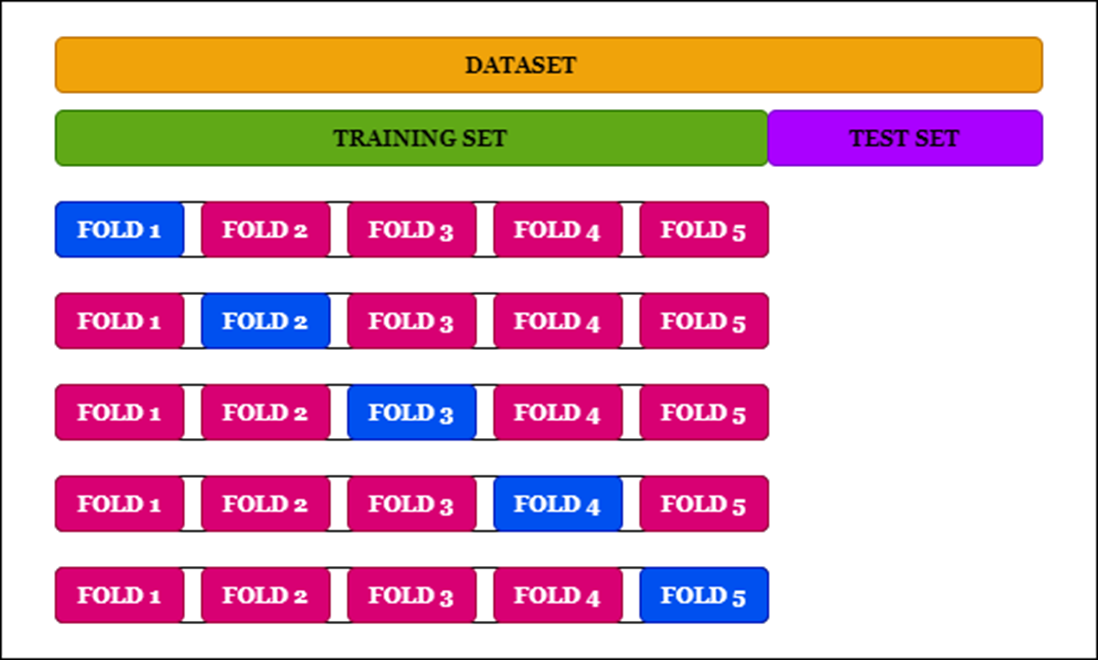

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
score1 = cross_val_score(model1, xtrain_pre, ytrain, scoring="r2", cv=5)
score1

array([0.92829237, 0.91127197, 0.90171948, 0.94551883, 0.90084967])

In [30]:
score1.mean()

np.float64(0.9175304649644047)

In [31]:
score1.std()

np.float64(0.017126422620961913)

In [33]:
model1.fit(xtrain_pre, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [34]:
model1.coef_

array([ 2.04868780e+03, -4.55409525e+03,  2.57740449e+03,  5.58788601e+01,
       -1.43406804e+02, -1.23522037e+02,  2.74147784e+02, -1.04815627e+02,
       -5.08096266e+01,  1.03621300e+02,  1.88463806e+01,  5.62951231e+01,
        2.40399164e+02, -4.42426717e+01,  2.84784672e+01, -2.98992049e+01,
        5.08191340e+01,  3.88278970e+00,  5.37264242e+01, -1.62021287e+01,
       -1.07346585e+01,  1.44934812e+01,  2.04583427e+01,  4.99720069e+01])

In [35]:
model1.intercept_

np.float64(3087.567567567568)

In [36]:
r2_train1 = model1.score(xtrain_pre, ytrain)
print(f"R2 score on train : {r2_train1:.2%}")

R2 score on train : 97.25%


In [37]:
r2_test1 = model1.score(xtest_pre, ytest)
print(f"R2 score in test : {r2_test1:.2%}")

R2 score in test : 82.17%


In [38]:
gen_err1 = abs(r2_train1 - r2_test1)
print(gen_err1)

0.1508315735143413


In [39]:
def evaluate_single_model(model, xtrain, ytrain, xtest, ytest):
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="r2")
    cv_mean = scores.mean().round(4)
    cv_std = scores.std().round(4)
    model.fit(xtrain, ytrain)
    r2_train = round(model.score(xtrain, ytrain), 4)
    r2_test = round(model.score(xtest, ytest), 4)
    gen_err = round(abs(r2_train - r2_test), 4)
    return {
        "model_name": type(model).__name__,
        "model": model,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "gen_err": gen_err,
    }

In [40]:
# Create a blank result list
results = []

In [41]:
r1 = evaluate_single_model(model1, xtrain_pre, ytrain, xtest_pre, ytest)
results.append(r1)
print(r1)

{'model_name': 'LinearRegression', 'model': LinearRegression(), 'cv_mean': np.float64(0.9175), 'cv_std': np.float64(0.0171), 'r2_train': 0.9725, 'r2_test': 0.8217, 'gen_err': 0.1508}


In [42]:
results

[{'model_name': 'LinearRegression',
  'model': LinearRegression(),
  'cv_mean': np.float64(0.9175),
  'cv_std': np.float64(0.0171),
  'r2_train': 0.9725,
  'r2_test': 0.8217,
  'gen_err': 0.1508}]

# Model 2 - With feature selection

In [50]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()
sel = SequentialFeatureSelector(
    base_model, n_features_to_select="auto", direction="forward"
).set_output(transform="pandas")
sel.fit(xtrain_pre, ytrain)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,None
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [51]:
sel_cols = sel.get_feature_names_out()
print(sel_cols)

['num__MPG.highway' 'num__Horsepower' 'num__RPM' 'num__Rev.per.mile'
 'num__Fuel.tank.capacity' 'num__Length' 'num__Wheelbase'
 'num__Luggage.room' 'cat__Manufacturer' 'cat__Type' 'cat__Cylinders'
 'cat__Origin']


In [52]:
len(sel_cols)

12

In [55]:
xtrain_pre_sel = sel.transform(xtrain_pre)
xtrain_pre_sel.head()

,num__MPG.highway,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,num__Luggage.room,cat__Manufacturer,cat__Type,cat__Cylinders,cat__Origin
42,0.363084,-0.070927,0.583333,0.553885,0.094849,0.075537,0.450415,0.028068,-0.330948,-1.373237,-0.763650,1.114641
53,1.322665,-0.759572,0.416667,-0.190474,-0.664766,-0.832796,-0.913114,-0.318105,0.266373,0.474391,-0.763650,1.114641
21,-0.596496,0.059357,-0.750000,-1.020721,-0.208997,1.333229,0.904925,1.066586,-0.928269,-0.757361,0.975122,-0.897150
6,-0.212664,0.487434,-0.750000,-1.431073,0.398695,1.123614,1.056428,1.066586,-1.286661,-0.757361,0.975122,-0.897150
26,-0.404580,-0.815408,-0.750000,0.277136,-0.208997,0.564640,0.147409,0.720413,-0.808804,-0.141485,-0.763650,-0.897150


In [56]:
xtest_pre_sel = sel.transform(xtest_pre)
xtest_pre_sel.head()

,num__MPG.highway,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,num__Luggage.room,cat__Manufacturer,cat__Type,cat__Cylinders,cat__Origin
34,0.171168,-0.536227,0.416667,0.038559,-0.360920,-0.343694,-0.155598,1.412758,-0.569876,1.090267,-0.763650,-0.897150
90,-0.788412,0.636330,0.916667,0.124447,0.550618,-1.741130,-1.064618,0.374241,1.699942,1.090267,0.975122,1.114641
3,-0.596496,0.524658,0.416667,0.410739,1.340618,0.634511,0.298912,1.066586,-1.525589,-0.141485,0.975122,1.114641
35,-1.747992,0.022133,-0.750000,-0.457680,1.310233,-0.553309,2.268454,0.028068,-0.569876,1.706143,0.975122,-0.897150
19,-0.212664,0.171029,0.083333,-0.629455,0.398695,1.333229,1.359435,0.374241,-1.764517,-0.757361,0.975122,-0.897150


In [57]:
model2 = LinearRegression()
r2 = evaluate_single_model(model2, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest)
results.append(r2)
print(r2)

{'model_name': 'LinearRegression', 'model': LinearRegression(), 'cv_mean': np.float64(0.9483), 'cv_std': np.float64(0.0167), 'r2_train': 0.966, 'r2_test': 0.8679, 'gen_err': 0.0981}


# Ridge (L2) - penalty applied on square of coefficients

In [58]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=1)
rr.fit(xtrain_pre_sel, ytrain)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [60]:
rr.score(xtrain_pre_sel, ytrain)

0.9658039953179488

In [61]:
rr.score(xtest_pre_sel, ytest)

0.8781098563939326

# Hyperparameter tuning - find best value of alpha

In [62]:
params = {"alpha": [0.1, 0.5, 1, 10, 50, 100, 500, 1000]}

In [63]:
from sklearn.model_selection import GridSearchCV

ridge_base = Ridge(random_state=42)
gscv_ridge = GridSearchCV(ridge_base, params, scoring="r2", cv=5)
gscv_ridge.fit(xtrain_pre_sel, ytrain)

,estimator,Ridge(random_state=42)
,param_grid,"{'alpha': [0.1, 0.5, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [64]:
gscv_ridge.best_params_

{'alpha': 1}

In [65]:
best_ridge = gscv_ridge.best_estimator_
best_ridge

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


In [66]:
gscv_ridge.best_score_

np.float64(0.9487786917560944)

In [67]:
r3 = evaluate_single_model(best_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest)
results.append(r3)
print(r3)

{'model_name': 'Ridge', 'model': Ridge(alpha=1, random_state=42), 'cv_mean': np.float64(0.9488), 'cv_std': np.float64(0.017), 'r2_train': 0.9658, 'r2_test': 0.8781, 'gen_err': 0.0877}


# Lasso

In [68]:
from sklearn.linear_model import Lasso

lasso_base = Lasso(random_state=42)
gscv_lasso = GridSearchCV(lasso_base, params, scoring="r2", cv=5)
gscv_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Lasso(random_state=42)
,param_grid,"{'alpha': [0.1, 0.5, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [69]:
gscv_lasso.best_params_

{'alpha': 1}

In [70]:
gscv_lasso.best_score_

np.float64(0.9486952161781591)

In [71]:
best_lasso = gscv_lasso.best_estimator_
best_lasso

,alpha,1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [72]:
r = evaluate_single_model(best_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest)
print(r)
results.append(r)

{'model_name': 'Lasso', 'model': Lasso(alpha=1, random_state=42), 'cv_mean': np.float64(0.9487), 'cv_std': np.float64(0.0173), 'r2_train': 0.9659, 'r2_test': 0.8788, 'gen_err': 0.0871}


# Try to add nonlinearity using polynomial regression

In [ ]:
# Polynomial features will add square, cube or other terms
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False).set_output(transform="pandas")
poly.fit_transform(xtrain_pre_sel)

,num__MPG.highway,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,num__Luggage.room,cat__Manufacturer,cat__Type,cat__Cylinders,cat__Origin,num__MPG.highway^2,num__MPG.highway num__Horsepower,num__MPG.highway num__RPM,num__MPG.highway num__Rev.per.mile,num__MPG.highway num__Fuel.tank.capacity,num__MPG.highway num__Length,num__MPG.highway num__Wheelbase,num__MPG.highway num__Luggage.room,num__MPG.highway cat__Manufacturer,num__MPG.highway cat__Type,num__MPG.highway cat__Cylinders,num__MPG.highway cat__Origin,num__Horsepower^2,num__Horsepower num__RPM,num__Horsepower num__Rev.per.mile,num__Horsepower num__Fuel.tank.capacity,num__Horsepower num__Length,num__Horsepower num__Wheelbase,num__Horsepower num__Luggage.room,num__Horsepower cat__Manufacturer,num__Horsepower cat__Type,num__Horsepower cat__Cylinders,num__Horsepower cat__Origin,num__RPM^2,num__RPM num__Rev.per.mile,num__RPM num__Fuel.tank.capacity,num__RPM num__Length,num__RPM num__Wheelbase,...,num__Rev.per.mile cat__Manufacturer,num__Rev.per.mile cat__Type,num__Rev.per.mile cat__Cylinders,num__Rev.per.mile cat__Origin,num__Fuel.tank.capacity^2,num__Fuel.tank.capacity num__Length,num__Fuel.tank.capacity num__Wheelbase,num__Fuel.tank.capacity num__Luggage.room,num__Fuel.tank.capacity cat__Manufacturer,num__Fuel.tank.capacity cat__Type,num__Fuel.tank.capacity cat__Cylinders,num__Fuel.tank.capacity cat__Origin,num__Length^2,num__Length num__Wheelbase,num__Length num__Luggage.room,num__Length cat__Manufacturer,num__Length cat__Type,num__Length cat__Cylinders,num__Length cat__Origin,num__Wheelbase^2,num__Wheelbase num__Luggage.room,num__Wheelbase cat__Manufacturer,num__Wheelbase cat__Type,num__Wheelbase cat__Cylinders,num__Wheelbase cat__Origin,num__Luggage.room^2,num__Luggage.room cat__Manufacturer,num__Luggage.room cat__Type,num__Luggage.room cat__Cylinders,num__Luggage.room cat__Origin,cat__Manufacturer^2,cat__Manufacturer cat__Type,cat__Manufacturer cat__Cylinders,cat__Manufacturer cat__Origin,cat__Type^2,cat__Type cat__Cylinders,cat__Type cat__Origin,cat__Cylinders^2,cat__Cylinders cat__Origin,cat__Origin^2
42,0.363084,-0.070927,0.583333,0.553885,0.094849,0.075537,0.450415,0.028068,-0.330948,-1.373237,-0.763650,1.114641,0.131830,-0.025752,0.211799,0.201107,0.034438,0.027426,0.163539,0.010191,-0.120162,-0.498601,-0.277269,0.404709,0.005031,-0.041374,-0.039285,-0.006727,-0.005358,-0.031947,-0.001991,0.023473,0.097399,0.054163,-0.079058,0.340278,0.323099,0.055329,0.044063,0.262742,...,-0.183307,-0.760615,-0.422974,0.617382,0.008996,0.007165,0.042722,0.002662,-0.031390,-0.130250,-0.072432,0.105723,0.005706,0.034023,0.002120,-0.024999,-0.103730,-0.057684,0.084197,0.202874,0.012642,-0.149064,-0.618527,-0.343959,0.502051,0.000788,-0.009289,-0.038544,-0.021434,0.031286,0.109527,0.454470,0.252728,-0.368888,1.885780,1.048672,-1.530666,0.583161,-0.851195,1.242424
53,1.322665,-0.759572,0.416667,-0.190474,-0.664766,-0.832796,-0.913114,-0.318105,0.266373,0.474391,-0.763650,1.114641,1.749442,-1.004659,0.551110,-0.251934,-0.879262,-1.101510,-1.207744,-0.420746,0.352322,0.627460,-1.010052,1.474296,0.576949,-0.316488,0.144679,0.504937,0.632568,0.693576,0.241623,-0.202329,-0.360334,0.580047,-0.846650,0.173611,-0.079364,-0.276986,-0.346998,-0.380464,...,-0.050737,-0.090359,0.145456,-0.212311,0.441914,0.553614,0.607007,0.211465,-0.177075,-0.315359,0.507648,-0.740975,0.693550,0.760438,0.264916,-0.221834,-0.395071,0.635965,-0.928269,0.833778,0.290466,-0.243229,-0.433173,0.697299,-1.017794,0.101190,-0.084734,-0.150906,0.242920,-0.354572,0.070954,0.126365,-0.203415,0.296910,0.225047,-0.362268,0.528776,0.583161,-0.851195,1.242424
21,-0.596496,0.059357,-0.750000,-1.020721,-0.208997,1.333229,0.904925,1.066586,-0.928269,-0.757361,0.975122,-0.897150,0.355807,-0.035406,0.447372,0.608856,0.124666,-0.795266,-0.539784,-0.636214,0.553708,0.451763,-0.581656,0.535146,0.003523,-0.044518,-0.060587,-0.012405,0.079137,0.053714,0.063310,-0.055099,-0.044955,0.057881,-0.05

In [76]:
poly_ridge = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), Ridge(random_state=42)
)

params = {"ridge__alpha": [0.1, 0.5, 1, 10, 50, 100, 500, 1000]}

gscv_poly_ridge = GridSearchCV(poly_ridge, params, scoring="r2", cv=5)
gscv_poly_ridge.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'ridge__alpha': [0.1, 0.5, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [77]:
gscv_poly_ridge.best_score_

np.float64(0.9360520070121542)

In [78]:
gscv_poly_ridge.best_params_

{'ridge__alpha': 10}

In [79]:
best_poly_ridge = gscv_poly_ridge.best_estimator_
best_poly_ridge

,steps,"[('polynomialfeatures', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,10
,fit_intercept,True
,copy_X,True


In [80]:
r = evaluate_single_model(best_poly_ridge, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest)
print(r)
results.append(r)

{'model_name': 'Pipeline', 'model': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=10, random_state=42))]), 'cv_mean': np.float64(0.9361), 'cv_std': np.float64(0.0317), 'r2_train': 0.9878, 'r2_test': 0.8525, 'gen_err': 0.1353}


# Polynomial with Lasso

In [81]:
poly_lasso = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), Lasso(random_state=42)
)

params = {"lasso__alpha": [0.1, 0.5, 1, 10, 50, 100, 500, 1000]}

gscv_poly_lasso = GridSearchCV(poly_lasso, params, scoring="r2", cv=5)
gscv_poly_lasso.fit(xtrain_pre_sel, ytrain)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lasso__alpha': [0.1, 0.5, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,2


In [82]:
gscv_poly_lasso.best_score_

np.float64(0.9341780210894818)

In [83]:
best_poly_lasso = gscv_poly_lasso.best_estimator_
best_poly_lasso

,steps,"[('polynomialfeatures', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,alpha,10
,fit_intercept,True
,precompute,False


In [84]:
gscv_poly_lasso.best_params_

{'lasso__alpha': 10}

In [85]:
r = evaluate_single_model(best_poly_lasso, xtrain_pre_sel, ytrain, xtest_pre_sel, ytest)
print(r)
results.append(r)

{'model_name': 'Pipeline', 'model': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=10, random_state=42))]), 'cv_mean': np.float64(0.9342), 'cv_std': np.float64(0.0259), 'r2_train': 0.9766, 'r2_test': 0.8019, 'gen_err': 0.1747}


In [86]:
results

[{'model_name': 'LinearRegression',
  'model': LinearRegression(),
  'cv_mean': np.float64(0.9175),
  'cv_std': np.float64(0.0171),
  'r2_train': 0.9725,
  'r2_test': 0.8217,
  'gen_err': 0.1508},
 {'model_name': 'LinearRegression',
  'model': LinearRegression(),
  'cv_mean': np.float64(0.9483),
  'cv_std': np.float64(0.0167),
  'r2_train': 0.966,
  'r2_test': 0.8679,
  'gen_err': 0.0981},
 {'model_name': 'Ridge',
  'model': Ridge(alpha=1, random_state=42),
  'cv_mean': np.float64(0.9488),
  'cv_std': np.float64(0.017),
  'r2_train': 0.9658,
  'r2_test': 0.8781,
  'gen_err': 0.0877},
 {'model_name': 'Lasso',
  'model': Lasso(alpha=1, random_state=42),
  'cv_mean': np.float64(0.9487),
  'cv_std': np.float64(0.0173),
  'r2_train': 0.9659,
  'r2_test': 0.8788,
  'gen_err': 0.0871},
 {'model_name': 'Pipeline',
  'model': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                  ('ridge', Ridge(alpha=10, random_state=42))]),
  'cv_mean': np.float64(0.

In [87]:
results_df = pd.DataFrame(results)
results_df

,model_name,model,cv_mean,cv_std,r2_train,r2_test,gen_err
0,LinearRegression,LinearRegression(),0.9175,0.0171,0.9725,0.8217,0.1508
1,LinearRegression,LinearRegression(),0.9483,0.0167,0.9660,0.8679,0.0981
2,Ridge,"Ridge(alpha=1, random_state=42)",0.9488,0.0170,0.9658,0.8781,0.0877
3,Lasso,"Lasso(alpha=1, random_state=42)",0.9487,0.0173,0.9659,0.8788,0.0871
4,Pipeline,"(PolynomialFeatures(include_bias=False), Ridge...",0.9361,0.0317,0.9878,0.8525,0.1353
5,Pipeline,"(PolynomialFeatures(include_bias=False), Lasso...",0.9342,0.0259,0.9766,0.8019,0.1747


In [89]:
sorted_df = results_df.sort_values(by="cv_mean", ascending=False).reset_index(drop=True)

In [90]:
sorted_df

,model_name,model,cv_mean,cv_std,r2_train,r2_test,gen_err
0,Ridge,"Ridge(alpha=1, random_state=42)",0.9488,0.0170,0.9658,0.8781,0.0877
1,Lasso,"Lasso(alpha=1, random_state=42)",0.9487,0.0173,0.9659,0.8788,0.0871
2,LinearRegression,LinearRegression(),0.9483,0.0167,0.9660,0.8679,0.0981
3,Pipeline,"(PolynomialFeatures(include_bias=False), Ridge...",0.9361,0.0317,0.9878,0.8525,0.1353
4,Pipeline,"(PolynomialFeatures(include_bias=False), Lasso...",0.9342,0.0259,0.9766,0.8019,0.1747
5,LinearRegression,LinearRegression(),0.9175,0.0171,0.9725,0.8217,0.1508


In [91]:
best_model = sorted_df.loc[0, "model"]
best_model

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


# Out of sample prediction

In [93]:
import pandas as pd

xnew = pd.read_csv("sample.csv", na_values=["", "NA"], keep_default_na=False)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,4,2.0,110,5200,2665,Yes,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,4,2.2,110,5200,2595,No,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,rotary,1.3,255,6500,2325,Yes,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,4,1.8,81,5500,2550,Yes,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox


In [94]:
best_model

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


In [95]:
xnew_pre = pre.transform(xnew)
xnew_pre_sel = sel.transform(xnew_pre)

In [96]:
xnew_pre_sel

,num__MPG.highway,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,num__Length,num__Wheelbase,num__Luggage.room,cat__Manufacturer,cat__Type,cat__Cylinders,cat__Origin
0,-0.596496,0.524658,0.416667,0.410739,-0.512843,0.424896,0.298912,1.066586,-1.525589,-0.141485,0.975122,1.114641
1,0.363084,-0.629288,-0.083333,0.658858,-0.452074,-0.203950,-0.458604,-0.318105,0.983157,-1.373237,-0.763650,-0.897150
2,-0.020748,-0.629288,-0.083333,0.525255,-0.057074,0.983870,0.601918,0.720413,-1.047733,-0.141485,-0.763650,-0.897150
3,-0.788412,2.069456,2.083333,0.009930,1.006387,-1.042412,-1.216121,0.028068,0.266373,1.090267,-2.502421,1.114641
4,0.746917,-1.169036,0.416667,0.439368,-1.302842,-1.461642,-1.670631,-1.356622,1.699942,0.474391,-0.763650,1.114641


In [98]:
preds = best_model.predict(xnew_pre_sel)
preds

array([3300.2903705 , 2664.92140017, 3109.36913408, 3328.45984932,
       2277.14963959])

In [99]:
xnew["Weight"] = preds.round(2)

In [100]:
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,RPM,Rev.per.mile,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make,Weight
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,2.8,172,5500,2535,Yes,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100,3300.29
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,4,2.0,110,5200,2665,Yes,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird,2664.92
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,4,2.2,110,5200,2595,No,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina,3109.37
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,rotary,1.3,255,6500,2325,Yes,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7,3328.46
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,4,1.8,81,5500,2550,Yes,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox,2277.15


In [101]:
xnew.to_csv("results.csv", index=False)